In [6]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
import joblib
import keras_tuner as kt
from sklearn.model_selection import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

# Verificar que la GPU está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU disponible.")
else:
    print("GPU no disponible.")

GPU no disponible.


In [7]:
# Crear la carpeta 'resultados' si no existe
if not os.path.exists('resultados'):
    os.makedirs('resultados')

In [8]:
# Cargar los datos
cleaned_data_path = '../datasets/cleaned_data.csv'
data_all = pd.read_csv(cleaned_data_path)

C:\Users\Ketbome\AppData\Local\Temp\ipykernel_18888\909222528.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv(cleaned_data_path)


In [9]:
data_all.head()

,ï»¿AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,COD_COM_ALU,NOM_COM_ALU,COD_RAMA,COD_SEC,COD_ESPE,PROM_GRAL,ASISTENCIA,SIT_FIN,SIT_FIN_R,COD_MEN
0,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,6.6,98,P,P,0
1,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,6.2,85,P,P,0
2,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,6.3,86,P,P,0
3,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,6.3,100,P,P,0
4,2022,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,...,15101,ARICA,400,410,41001,6.7,100,P,P,0


In [10]:
# Convertir la columna a números, los valores inválidos se convierten en NaN
data_all['EDAD_ALU'] = pd.to_numeric(data_all['EDAD_ALU'], errors='coerce')

# Eliminar las filas con NaN en la columna 'EDAD_ALU'
data_all = data_all.dropna(subset=['EDAD_ALU'])

# Borrar las filas donde la columna 'COD_SEC' sea distinto de 0
data_all = data_all[data_all['COD_SEC'] == 0] # Solo alumnos de basica y media

# Eliminar la columna 'COD_ENSE'
data_all = data_all.drop(columns=['COD_ENSE'])

In [11]:
data_all.describe()

,ï»¿AGNO,RBD,DGV_RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,COD_DEPROV_RBD,COD_DEPE,COD_DEPE2,RURAL_RBD,...,FEC_NAC_ALU,EDAD_ALU,COD_REG_ALU,COD_COM_ALU,COD_RAMA,COD_SEC,COD_ESPE,PROM_GRAL,ASISTENCIA,COD_MEN
count,2929038.0,2.929038e+06,2.929038e+06,2.929038e+06,2.929038e+06,2.929038e+06,2.929038e+06,2.929038e+06,2.929038e+06,2.929038e+06,...,2.929038e+06,2.929038e+06,2.929038e+06,2.929038e+06,2929038.0,2929038.0,2929038.0,2.929038e+06,2.929038e+06,2929038.0
mean,2022.0,1.174098e+04,4.448446e+00,9.420291e+00,9.614138e+01,9.620775e+03,9.474121e+01,2.840051e+00,1.944492e+00,8.055819e-02,...,2.009520e+05,1.203774e+01,9.492722e+00,9.689866e+03,0.0,0.0,0.0,6.034377e+00,8.803276e+01,0.0
std,0.0,9.073623e+03,2.881730e+00,3.998147e+00,3.976902e+01,3.979691e+03,3.934226e+01,1.084668e+00,9.411082e-01,2.721555e-01,...,5.226045e+02,5.219115e+00,4.014266e+00,3.995987e+03,0.0,0.0,0.0,6.856856e-01,1.130574e+01,0.0
min,2022.0,1.000000e+00,0.000000e+00,1.000000e+00,1.100000e+01,1.101000e+03,1.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00,...,1.930110e+05,3.000000e+00,1.000000e+00,1.101000e+03,0.0,0.0,0.0,1.000000e+00,1.000000e+00,0.0
25%,2022.0,4.588000e+03,2.000000e+00,6.000000e+00,6.100000e+01,6.107000e+03,6.100000e+01,2.000000e+00,1.000000e+00,0.000000e+00,...,2.007070e+05,9.000000e+00,6.000000e+00,6.108000e+03,0.0,0.0,0.0,5.700000e+00,8.500000e+01,0.0
50%,2022.0,9.828000e+03,4.000000e+00,1.000000e+01,1.010000e+02,1.010100e+04,9.200000e+01,3.000000e+00,2.000000e+00,0.000000e+00,...,2.010060e+05,1.200000e+01,1.000000e+01,1.010900e+04,0.0,0.0,0.0,6.200000e+00,9.000000e+01,0.0
75%,2022.0,1.677600e+04,7.000000e+00,1.300000e+01,1.310000e+02,1.312200e+04,1.340000e+02,3.000000e+00,2.000000e+00,0.000000e+00,...,2.013040e+05,1.400000e+01,1.300000e+01,1.312200e+04,0.0,0.0,0.0,6.500000e+00,9.500000e+01,0.0
max,2022.0,4.213000e+04,9.000000e+00,1.600000e+01,1.630000e+02,1.630500e+04,1.510000e+02,6.000000e+00,5.000000e+00,1.000000e+00,...,2.018120e+05,9.100000e+01,1.600000e+01,1.630500e+04,0.0,0.0,0.0,7.000000e+00,1.000000e+02,0.0


In [12]:
data_all.isna().sum()

ï»¿AGNO           0
RBD               0
DGV_RBD           0
NOM_RBD           0
COD_REG_RBD       0
NOM_REG_RBD_A     0
COD_PRO_RBD       0
COD_COM_RBD       0
NOM_COM_RBD       0
COD_DEPROV_RBD    0
NOM_DEPROV_RBD    0
COD_DEPE          0
COD_DEPE2         0
RURAL_RBD         0
ESTADO_ESTAB      0
COD_ENSE2         0
COD_GRADO         0
LET_CUR           0
COD_JOR           0
COD_TIP_CUR       0
COD_DES_CUR       0
MRUN              0
GEN_ALU           0
FEC_NAC_ALU       0
EDAD_ALU          0
COD_REG_ALU       0
COD_COM_ALU       0
NOM_COM_ALU       0
COD_RAMA          0
COD_SEC           0
COD_ESPE          0
PROM_GRAL         0
ASISTENCIA        0
SIT_FIN           0
SIT_FIN_R         0
COD_MEN           0
dtype: int64

In [13]:
data_all = data_all.dropna()

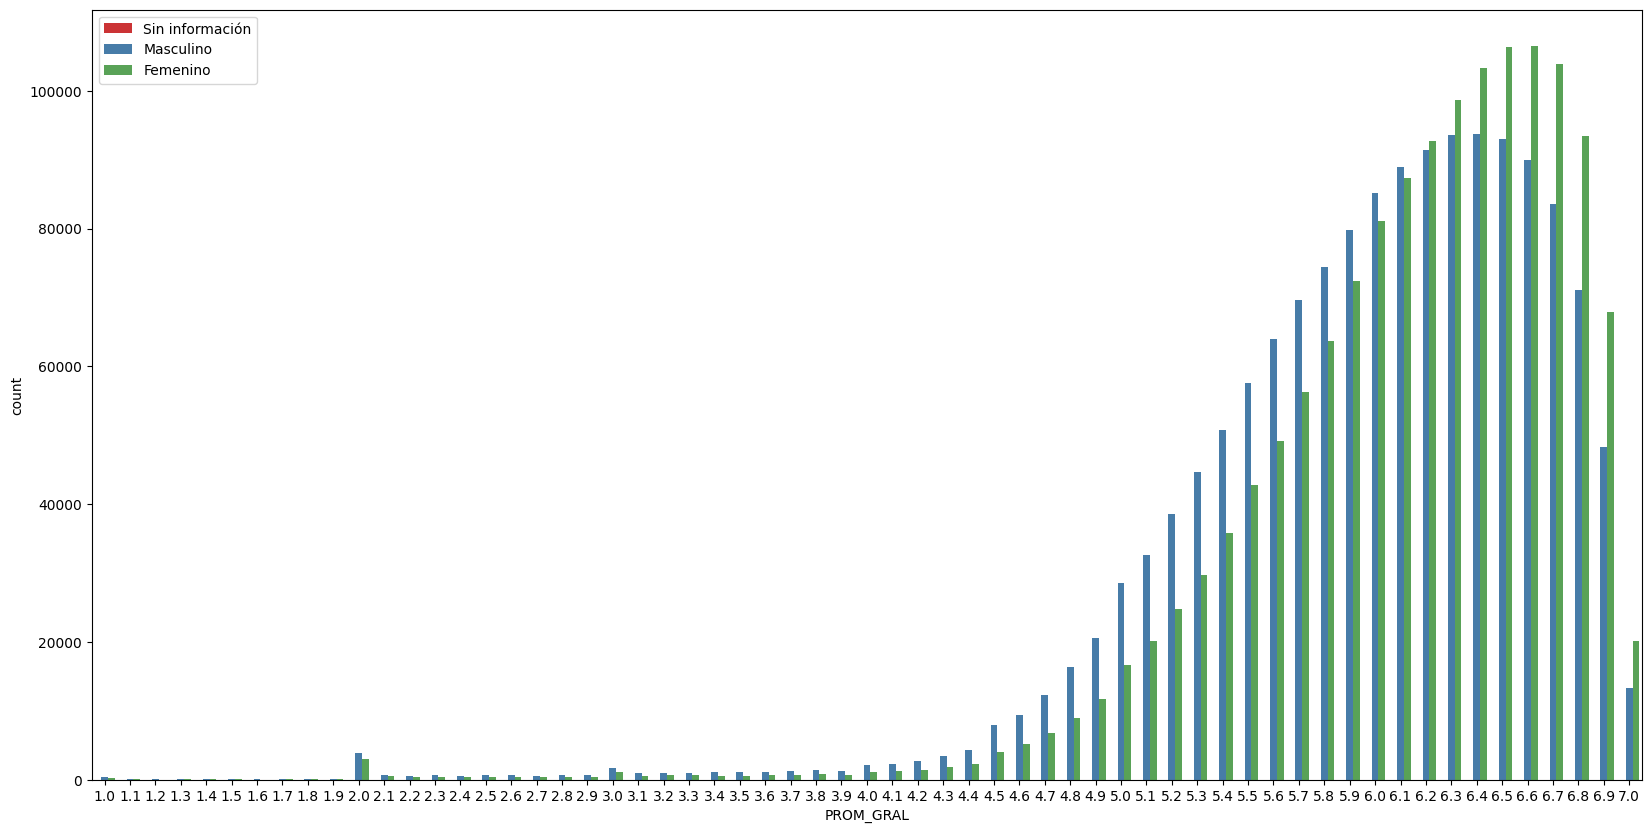

In [14]:
import seaborn as sb
import matplotlib.pyplot as plt


plt.figure(figsize=(20,10))
sb.countplot(x='PROM_GRAL', data=data_all, hue='GEN_ALU', palette='Set1')
plt.legend(["Sin información", "Masculino", "Femenino"])


In [15]:
# Observar correlacion para hacer mas limpieza
numeric_columns = data_all.select_dtypes(include=np.number).columns
correlacion_all = data_all[numeric_columns].corr()

# Ver correlacion en base a valor a evaluar
correlacion_prom_gral = correlacion_all["PROM_GRAL"].sort_values(ascending=False)
correlacion_prom_gral

PROM_GRAL         1.000000
ASISTENCIA        0.353526
FEC_NAC_ALU       0.346272
GEN_ALU           0.113676
COD_DEPE          0.057404
MRUN              0.054466
COD_DEPE2         0.049517
RURAL_RBD         0.027529
COD_TIP_CUR       0.021308
DGV_RBD          -0.003853
COD_REG_ALU      -0.009950
COD_COM_ALU      -0.010334
COD_REG_RBD      -0.015331
COD_COM_RBD      -0.015470
COD_PRO_RBD      -0.015492
COD_DEPROV_RBD   -0.022988
RBD              -0.036958
COD_GRADO        -0.052895
COD_JOR          -0.084066
COD_ENSE2        -0.257659
EDAD_ALU         -0.348045
ï»¿AGNO                NaN
ESTADO_ESTAB           NaN
COD_DES_CUR            NaN
COD_RAMA               NaN
COD_SEC                NaN
COD_ESPE               NaN
COD_MEN                NaN
Name: PROM_GRAL, dtype: float64

In [40]:
# Obtener nombres de las columnas de correlacion distintas que no sean Nan
columnas_seleccionadas = correlacion_prom_gral[correlacion_prom_gral.notna()].index


In [16]:
# Obtén los nombres de las columnas con correlación mayor a 0.1
columnas_mayor_0_1 = correlacion_prom_gral[correlacion_prom_gral > 0.057].index

# Obtén los nombres de las columnas con correlación menor a -0.1
columnas_menor_neg_0_1 = correlacion_prom_gral[correlacion_prom_gral < -0.05].index

columnas_seleccionadas = columnas_mayor_0_1.tolist() + columnas_menor_neg_0_1.tolist()

# Agregar comuna del colegio
columnas_seleccionadas.append('COD_COM_RBD')
#columnas_seleccionadas.append('DGV_RBD')

columnas_seleccionadas

['PROM_GRAL',
 'ASISTENCIA',
 'FEC_NAC_ALU',
 'GEN_ALU',
 'COD_DEPE',
 'COD_GRADO',
 'COD_JOR',
 'COD_ENSE2',
 'EDAD_ALU',
 'COD_COM_RBD']

In [41]:
# Columnas
#['ï»¿AGNO', 'RBD', 'DGV_RBD', 'NOM_RBD', 'COD_REG_RBD', 'NOM_REG_RBD_A', 'COD_PRO_RBD', 'COD_COM_RBD', 
#'NOM_COM_RBD', 'COD_DEPROV_RBD', 'NOM_DEPROV_RBD', 'COD_DEPE', 'COD_DEPE2', 'RURAL_RBD', 'ESTADO_ESTAB',
#'COD_ENSE', 'COD_ENSE2', 'COD_GRADO', 'LET_CUR', 'COD_JOR',
#'COD_TIP_CUR', 'COD_DES_CUR', 'MRUN', 'GEN_ALU', 'FEC_NAC_ALU',
#'EDAD_ALU', 'COD_REG_ALU', 'COD_COM_ALU', 'NOM_COM_ALU', 'COD_RAMA',
#'COD_SEC', 'COD_ESPE', 'PROM_GRAL', 'ASISTENCIA', 'SIT_FIN',
#'SIT_FIN_R', 'COD_MEN']

# Hacer data = data_all con las columnas a usar EDAD_ALU, GEN_ALU, PROM_GRAL
#data = data_all.drop(['NOM_COM_RBD', 'NOM_DEPROV_RBD', 'NOM_RBD', 'NOM_REG_RBD_A', 'COD_ESPE', 'COD_MEN', 'COD_SEC', 'COD_RAMA', 'COD_DES_CUR', 'ESTADO_ESTAB', 'ï»¿AGNO'])
data_clear = data_all[columnas_seleccionadas]
data = data_clear.drop('FEC_NAC_ALU', axis=1)
data.head()

,PROM_GRAL,ASISTENCIA,FEC_NAC_ALU,GEN_ALU,COD_DEPE,MRUN,COD_DEPE2,RURAL_RBD,COD_TIP_CUR,DGV_RBD,...,COD_COM_ALU,COD_REG_RBD,COD_COM_RBD,COD_PRO_RBD,COD_DEPROV_RBD,RBD,COD_GRADO,COD_JOR,COD_ENSE2,EDAD_ALU
7,4.5,85,200804,1,6,599765,5,0,0,9,...,4102,15,15101,151,151,1,1,1,7,14.0
8,5.1,89,200704,1,6,1318200,5,0,0,9,...,15101,15,15101,151,151,1,1,1,7,15.0
9,5.3,89,200510,1,6,3533695,5,0,0,9,...,15101,15,15101,151,151,1,1,1,7,16.0
10,5.9,90,200604,2,6,3734858,5,0,0,9,...,15101,15,15101,151,151,1,1,1,7,16.0
11,5.7,90,200801,1,6,4707139,5,0,0,9,...,15101,15,15101,151,151,1,1,1,7,14.0


In [18]:
data.head()

,PROM_GRAL,ASISTENCIA,FEC_NAC_ALU,GEN_ALU,COD_DEPE,COD_GRADO,COD_JOR,COD_ENSE2,EDAD_ALU,COD_COM_RBD
7,4.5,85,200804,1,6,1,1,7,14.0,15101
8,5.1,89,200704,1,6,1,1,7,15.0,15101
9,5.3,89,200510,1,6,1,1,7,16.0,15101
10,5.9,90,200604,2,6,1,1,7,16.0,15101
11,5.7,90,200801,1,6,1,1,7,14.0,15101


<Axes: >

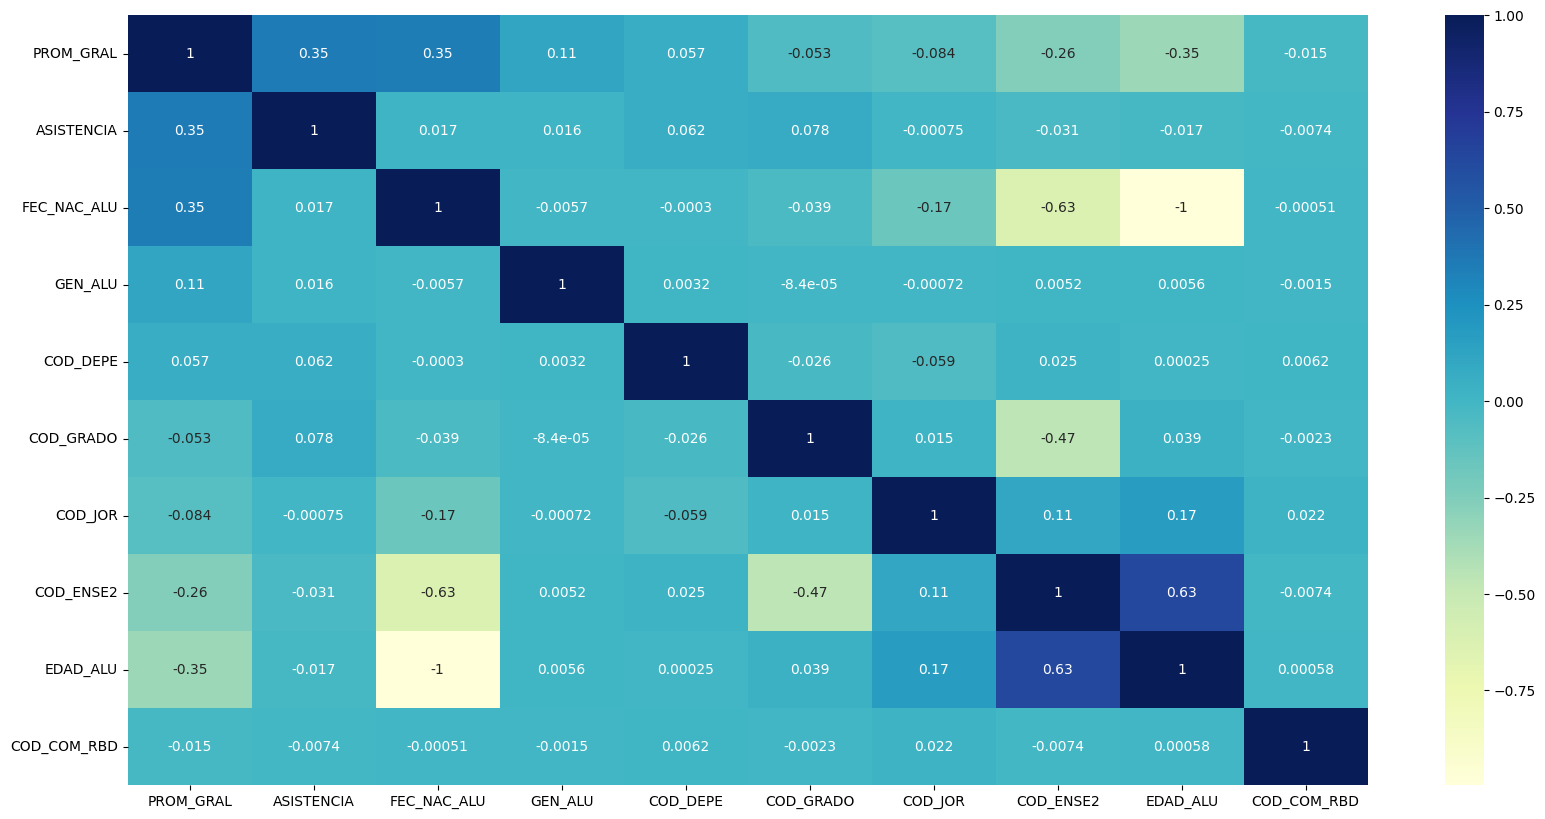

In [19]:
#Observar correlacion para hacer mas limpieza
plt.figure(figsize=(20,10))
sb.heatmap(data.corr(), annot=True, cmap='YlGnBu')


In [31]:
# Ver correlacion en base a valor a evaluar
data.corr()["PROM_GRAL"].sort_values(ascending=False)

PROM_GRAL         1.000000
ASISTENCIA        0.353526
FEC_NAC_ALU       0.346272
GEN_ALU           0.113676
COD_DEPE          0.057404
MRUN              0.054466
COD_DEPE2         0.049517
RURAL_RBD         0.027529
COD_TIP_CUR       0.021308
DGV_RBD          -0.003853
COD_REG_ALU      -0.009950
COD_COM_ALU      -0.010334
COD_REG_RBD      -0.015331
COD_COM_RBD      -0.015470
COD_PRO_RBD      -0.015492
COD_DEPROV_RBD   -0.022988
RBD              -0.036958
COD_GRADO        -0.052895
COD_JOR          -0.084066
COD_ENSE2        -0.257659
EDAD_ALU         -0.348045
Name: PROM_GRAL, dtype: float64

In [32]:
# Saber cuantas filas hay y columnas
pd.DataFrame([data.shape], columns=['Filas', 'Columnas'])

,Filas,Columnas
0,2929038,21


In [33]:
# División de datos
X = data.drop(columns=['PROM_GRAL'])
y = data['PROM_GRAL']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [34]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Especificar modelo


In [144]:
def model_builder(hp):
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=64)
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=128)
    hp_layers = hp.Int('layers', min_value=1, max_value=3, step=1)

    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))

    for i in range(hp_layers):
        if i == 0:
            model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
        elif i == 1:
            model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
        elif i == 2:
            model.add(keras.layers.Dense(units=hp_units3, activation='relu'))

    model.add(keras.layers.Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

In [35]:
def model_builder(hp):
    hp_units = hp.Int('units', min_value=32, max_value=512, step=64)

    model = keras.Sequential([
        layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
        layers.Dense(units=hp_units, activation='relu'),
        layers.Dense(1)
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mae',
        metrics=['mse']
    )

    return model

### Monitoreo del modelo con Early Stopping

In [36]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        # Numero de iteraciones sin mejora
        patience=5,
    )
]

### Busqueda usando hyperband


In [37]:
hyperband_tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=10,
    factor=10, # Numero de iteraciones por modelo
    directory='/tmp/hyperband',
    project_name='tuning_rnn',
    overwrite=True
)

hyperband_tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
hyperband_tuner.search(
    X_train_scaled,
    y_train,
    epochs=30,
    batch_size=512,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

hyperband_tuner.results_summary()

Trial 13 Complete [00h 01m 55s]
val_loss: 0.40647420287132263

Best val_loss So Far: 0.40647420287132263
Total elapsed time: 00h 06m 03s
Results summary
Results in /tmp/hyperband\tuning_rnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0012 summary
Hyperparameters:
units: 224
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.40647420287132263

Trial 0010 summary
Hyperparameters:
units: 480
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 1
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0005
Score: 0.4078018069267273

Trial 0011 summary
Hyperparameters:
units: 96
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.4140383303165436

Trial 0005 summary
Hyperparameters:
units: 480
learning_rate: 0.001
tuner/epochs: 1
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.4147869050502777

Trial 0009 summary
Hyperparameters:
units: 96
learnin

### Busqueda RandomSearch

In [35]:
randomsearch_tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    factor=5, # Numero de iteraciones por modelo
    directory='/tmp/randomsearch',
    project_name='tuning_rnn',
    overwrite=True
)

randomsearch_tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [36]:
randomsearch_tuner.search(
    X_train_scaled,
    y_train,
    epochs=30,
    batch_size=1024,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

randomsearch_tuner.results_summary()

Trial 10 Complete [00h 02m 57s]
val_loss: 0.26760002970695496

Best val_loss So Far: 0.26703357696533203
Total elapsed time: 00h 21m 29s
Results summary
Results in /tmp/randomsearch\tuning_rnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
units: 288
learning_rate: 0.001
Score: 0.26703357696533203

Trial 01 summary
Hyperparameters:
units: 416
learning_rate: 0.001
Score: 0.26737555861473083

Trial 09 summary
Hyperparameters:
units: 384
learning_rate: 0.0001
Score: 0.26760002970695496

Trial 08 summary
Hyperparameters:
units: 320
learning_rate: 0.001
Score: 0.2676885724067688

Trial 07 summary
Hyperparameters:
units: 288
learning_rate: 0.0001
Score: 0.2677406370639801

Trial 05 summary
Hyperparameters:
units: 352
learning_rate: 0.0001
Score: 0.26779240369796753

Trial 00 summary
Hyperparameters:
units: 448
learning_rate: 0.01
Score: 0.2694186568260193

Trial 03 summary
Hyperparameters:
units: 288
learning_rate: 0.01
Score: 0.27001106

In [41]:
bayesian_tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=10,
    factor=5, # Numero de iteraciones por modelo
    directory='/tmp/bayesian',
    project_name='tuning_rnn',
    overwrite=True
)

bayesian_tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [42]:
bayesian_tuner.search(
    X_train_scaled,
    y_train,
    epochs=30,
    batch_size=1024,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

bayesian_tuner.results_summary()

Trial 10 Complete [00h 03m 23s]
val_loss: 0.26722031831741333

Best val_loss So Far: 0.26708799600601196
Total elapsed time: 00h 24m 22s
Results summary
Results in /tmp/bayesian\tuning_rnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
units: 512
learning_rate: 0.0001
Score: 0.26708799600601196

Trial 07 summary
Hyperparameters:
units: 512
learning_rate: 0.0001
Score: 0.26715171337127686

Trial 09 summary
Hyperparameters:
units: 512
learning_rate: 0.0001
Score: 0.26722031831741333

Trial 02 summary
Hyperparameters:
units: 512
learning_rate: 0.0001
Score: 0.26728662848472595

Trial 06 summary
Hyperparameters:
units: 416
learning_rate: 0.0001
Score: 0.2674542963504791

Trial 03 summary
Hyperparameters:
units: 288
learning_rate: 0.0001
Score: 0.26798227429389954

Trial 01 summary
Hyperparameters:
units: 256
learning_rate: 0.01
Score: 0.2697976231575012

Trial 04 summary
Hyperparameters:
units: 32
learning_rate: 0.001
Score: 0.27014666

### Grid Search

In [112]:
#GridSearch
def build_regressor(optimizer, neurons, num_layers):
    regressor = Sequential()
    regressor.add(Dense(neurons, input_dim= X_train_scaled.shape[1],activation='relu'))
    for i in range(num_layers):
        regressor.add(Dense(neurons, activation='relu'))
        regressor.add(Dropout(0.2))
    regressor.add(Dense(1))
    regressor.add(Activation('sigmoid'))
    regressor.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return regressor

param_grid = {
    'neurons': [64],
    'num_layers': [0, 1],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [512],
}

model = KerasRegressor(build_fn=build_regressor, verbose=1, epochs=10)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1)

# Entrenamiento
grid_search = grid_search.fit(X_train_scaled, y_train)

C:\Users\Ketbome\AppData\Local\Temp\ipykernel_12132\3791955045.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_regressor, verbose=1, epochs=10)


ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python311\Lib\site-packages\keras\wrappers\scikit_learn.py", line 167, in fit
AttributeError: module 'keras.losses' has no attribute 'is_categorical_crossentropy'


In [91]:
# Entrenamiento
grid_search = grid_search.fit(X_train_scaled, y_train)

ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python311\Lib\site-packages\keras\wrappers\scikit_learn.py", line 167, in fit
AttributeError: module 'keras.losses' has no attribute 'is_categorical_crossentropy'


In [ ]:
# Mejores parámetros
best_parameters = grid_search.best_params_
print(best_parameters)

### Obtencion del mejor modelo

In [43]:
best_hyperband_model = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

best_hyperband_model.get('units'), best_hyperband_model.get('learning_rate')

(224, 0.001)

In [44]:
best_randomsearch_model = randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]

best_randomsearch_model.get('units'), best_randomsearch_model.get('learning_rate')

(288, 0.001)

In [45]:
best_bayesian_model = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

best_bayesian_model.get('units'), best_bayesian_model.get('learning_rate')

(512, 0.0001)

### Obtener mejor modelo

In [47]:
model = hyperband_tuner.hypermodel.build(best_hyperband_model)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
29291/29291 [==============================] - 77s 3ms/step - loss: 0.4343 - mse: 0.3654 - val_loss: 0.4174 - val_mse: 0.3061
Epoch 2/60
15624/29291 [===============>..............] - ETA: 30s - loss: 0.4160 - mse: 0.3102

KeyboardInterrupt: 

In [47]:
model2 = randomsearch_tuner.hypermodel.build(best_randomsearch_model)

history2 = model2.fit(
    X_train_scaled,
    y_train,
    epochs=60,
    batch_size=1024,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
1889/1889 [==============================] - 6s 3ms/step - loss: 1.0193 - mae: 0.6063 - val_loss: 0.2859 - val_mae: 0.4136
Epoch 2/60
1889/1889 [==============================] - 5s 3ms/step - loss: 0.2785 - mae: 0.4087 - val_loss: 0.2726 - val_mae: 0.4039
Epoch 3/60
1889/1889 [==============================] - 5s 3ms/step - loss: 0.2741 - mae: 0.4056 - val_loss: 0.2725 - val_mae: 0.4026
Epoch 4/60
1889/1889 [==============================] - 5s 3ms/step - loss: 0.2730 - mae: 0.4046 - val_loss: 0.2733 - val_mae: 0.4015
Epoch 5/60
1889/1889 [==============================] - 5s 3ms/step - loss: 0.2723 - mae: 0.4042 - val_loss: 0.2726 - val_mae: 0.4088
Epoch 6/60
1889/1889 [==============================] - 5s 3ms/step - loss: 0.2719 - mae: 0.4039 - val_loss: 0.2716 - val_mae: 0.4082
Epoch 7/60
1889/1889 [==============================] - 5s 3ms/step - loss: 0.2715 - mae: 0.4036 - val_loss: 0.2704 - val_mae: 0.4021
Epoch 8/60
1889/1889 [==============================] - 5s 3ms

In [48]:
model3 = bayesian_tuner.hypermodel.build(best_bayesian_model)

history3 = model3.fit(
    X_train_scaled,
    y_train,
    epochs=60,
    batch_size=1024,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
1889/1889 [==============================] - 8s 4ms/step - loss: 5.7457 - mae: 1.6608 - val_loss: 0.5587 - val_mae: 0.5723
Epoch 2/60
1889/1889 [==============================] - 6s 3ms/step - loss: 0.4626 - mae: 0.5143 - val_loss: 0.3928 - val_mae: 0.4717
Epoch 3/60
1889/1889 [==============================] - 7s 4ms/step - loss: 0.3570 - mae: 0.4514 - val_loss: 0.3209 - val_mae: 0.4312
Epoch 4/60
1889/1889 [==============================] - 6s 3ms/step - loss: 0.3025 - mae: 0.4221 - val_loss: 0.2852 - val_mae: 0.4121
Epoch 5/60
1889/1889 [==============================] - 7s 4ms/step - loss: 0.2805 - mae: 0.4098 - val_loss: 0.2747 - val_mae: 0.4064
Epoch 6/60
1889/1889 [==============================] - 6s 3ms/step - loss: 0.2750 - mae: 0.4063 - val_loss: 0.2726 - val_mae: 0.4045
Epoch 7/60
1889/1889 [==============================] - 6s 3ms/step - loss: 0.2734 - mae: 0.4051 - val_loss: 0.2714 - val_mae: 0.4041
Epoch 8/60
1889/1889 [==============================] - 6s 3ms